### Test the AC-GAN model

In [75]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline

In [76]:
MODEL_FOLDER = "models"

In [77]:
n_classes = 10
latent_dim = 100
img_size = 128
channels = 3
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, latent_dim)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [78]:
#load model back and test
cuda = True if torch.cuda.is_available() else False
PATH_TO_MODEL = "models/deepweeds_acgan_gan.pth"
gen_model = Generator()
gen_model.load_state_dict(torch.load(PATH_TO_MODEL))
gen_model.eval()
if cuda:
    gen_model.cuda()

In [79]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.title("Fake Images for label 3")
    if show:
        plt.show()

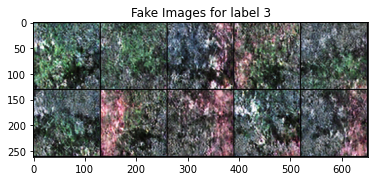

In [80]:
n_row = 5
z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
labels = np.array([3 for _ in range(n_row) for num in range(n_row)])
labels = Variable(LongTensor(labels))
gen_imgs = gen_model(z, labels)


show_tensor_images(gen_imgs, 10, (128,128))


#### Compare fake and real images for label 3

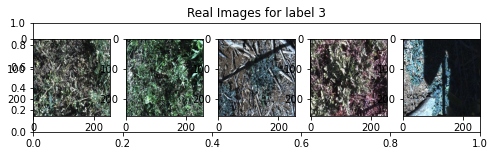

In [81]:
#display random real images from label 3

import os
import torchvision

data_dir = 'data/train/3'
filenames = [name for name in os.listdir(data_dir)]
batch_size = len(filenames)
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)
for i, filename in enumerate(filenames):
    batch[i] = torchvision.io.read_image(os.path.join(data_dir, filename))
fig = plt.figure(figsize=(8, 2))
plt.title("Real Images for label 3")
for i in range(5) :
    ax = fig.add_subplot(1, 5, i+1)
    num = np.random.randint(0, batch.shape[0], 1)[0]
    ax.imshow(batch[num].permute(1, 2, 0))

